# **OFFENSIVE TWEET DETECTION**

The objective of this project is creating a sequence classifier model to detect Turkish offensive tweets.
The preffered way of creating that model is fine-tuning a pre-trained language model on Turkish data. 

# **Training**

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 86 kB 5.6 MB/s 
     |████████████████████████████████| 6.6 MB 59.9 MB/s 
     |████████████████████████████████| 596 kB 59.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Importing necessary libraries.


> transformers library for using Hugging Face models, tokenizers.

> sklearn is used for calculating metrics in training part.

> pandas is used for reading dataset file and numpy is used for metric calculations.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import EarlyStoppingCallback

## Reading data

The dataset that we used in this project is OffensEval2020 which is published by Mukayese. Mukayese is an open-source dataset publishing community for Turkish language.
This dataset consists of tweets and they are classified according to offensive tweets and not-offensive tweets

Training Set : 31.277 tweets (6046 offensive)

Test Set : 3515 (716 offensive)

*Detailed Information: 
https://github.com/alisafaya/mukayese and
https://data.tdd.ai/#/53b6ca44-e95e-443d-bb9e-978327c59fc5*



As seen in below, dataset contains id column which is not explained and not used in this project, and columns are splitted by tabs. According to these, dataset is readed and corrected in the below code. 

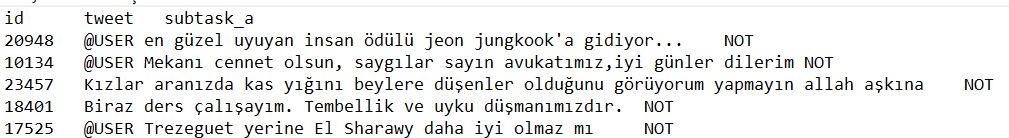

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/mukayese/train/offenseval-tr-training-v1.txt",  sep='\t')
data = data.drop(columns="id")
data.head()

,tweet,subtask_a
0,@USER en güzel uyuyan insan ödülü jeon jungkoo...,NOT
1,"@USER Mekanı cennet olsun, saygılar sayın avuk...",NOT
2,Kızlar aranızda kas yığını beylere düşenler ol...,NOT
3,Biraz ders çalışayım. Tembellik ve uyku düşman...,NOT
4,@USER Trezeguet yerine El Sharawy daha iyi olm...,NOT


## Defining Pre-trained Tokenizer and Model

The Hugging Face model that is used for fine tuninig and adapt to our task is dbmdz Turkish BERT model which is buit by the MDZ Digital Library team (dbmdz) at the Bavarian State Library.

*Detailed Information: https://huggingface.co/dbmdz/bert-base-turkish-cased*

Every NLP model in Hugging Face needs a tokenizer and model funtions to use them. These functions are included in transformers library.

In [ ]:
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/245k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-turkish-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were 

## Preprocessing the data

The Pandas DataFrame that we have created for trainng dataset includes tweets and their labels. Labels are "OFF" for offensive tweets and "NOT" for no-offensive tweets. To use this information in training, "OFF" represented with 1 and "NOT" represented with 0.

The dataset has no specific validation set, so we splitted train and validation set from training data.
To do this, we used *sklearn*'s *train_test_split* function (test in this function corresponds to validation set in our project) and choose the validation set 20% of the all training dataset.

After splitting train and validation data, we tokenized them with corresponding tokenizer.

In [ ]:
X = list(data["tweet"])
y = list(data["subtask_a"])
a = []
for i in y:
  if i =="OFF":
    a.append(1)
  else:
    a.append(0)
y = a
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

## Defining Trainer parameters

In [ ]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


## Defining Trainer and Training Pre-Trained Model

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 37312
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13992


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.098400,0.830167,0.887650,0.757640,0.601241,0.670440
1000,0.208400,0.550793,0.882719,0.749449,0.575296,0.650925
1500,0.399700,0.358510,0.894082,0.787125,0.606881,0.685350
2000,0.371200,0.308233,0.895154,0.854594,0.540327,0.662059
2500,0.335900,0.280175,0.902873,0.824233,0.621545,0.708682
3000,0.307800,0.339174,0.901265,0.880357,0.556120,0.681645
3500,0.314700,0.334258,0.906625,0.769093,0.727016,0.747463
4000,0.334100,0.261613,0.914558,0.812821,0.715172,0.760876
4500,0.296400,0.310847,0.910163,0.921551,0.576424,0.709230
5000,0.214300,0.394219,0.918203,0.886677,0.653130,0.752192


***** Running Evaluation *****
  Num examples = 9328
  Batch size = 8
Saving model checkpoint to output/checkpoint-500
Configuration saved in output/checkpoint-500/config.json
Model weights saved in output/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 9328
  Batch size = 8
Saving model checkpoint to output/checkpoint-1000
Configuration saved in output/checkpoint-1000/config.json
Model weights saved in output/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 9328
  Batch size = 8
Saving model checkpoint to output/checkpoint-1500
Configuration saved in output/checkpoint-1500/config.json
Model weights saved in output/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 9328
  Batch size = 8
Saving model checkpoint to output/checkpoint-2000
Configuration saved in output/checkpoint-2000/config.json
Model weights saved in output/checkpoint-2000/pytorch_model.bin
***** Running Evaluation *****
  Nu

KeyboardInterrupt: ignored

## Training Results

As you see in model results, while the training loss keeps decreasing, validation loss oscillates between 0.3 - 0.4. Because of that, we stopped the training and take the most reasonable checkpoint model at step 4000 which is the last step that the validation error keeps decreasing, as the trained model for our task.  

Model that trained above can be loaded in the code below.

In [ ]:
model_path = "/content/output/checkpoint-4000"
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

loading configuration file /content/output/checkpoint-4000/config.json
Model config BertConfig {
  "_name_or_path": "/content/output/checkpoint-4000",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading weights file /content/output/checkpoint-4000/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClas

With Hugging Face's pipeline function, we can use the model.

In [ ]:
from transformers import pipeline
trained = pipeline("text-classification", tokenizer=tokenizer, model=model)

# **COMPARISON** 
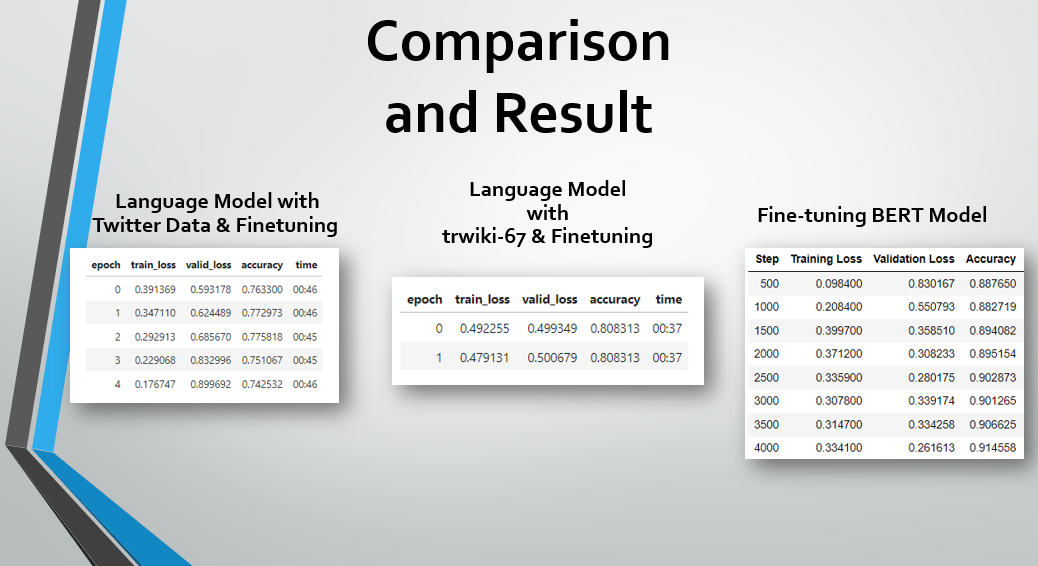

# **Other Models ipynb Files & Models Parameters**

Drive Link : https://drive.google.com/drive/folders/1UBKmPPOLCm1t3STmPCb4P5NEuhWz_xxY?usp=sharing 



